# Stock Price Prediction (NIFTY 50)

This project focuses on predicting the **NIFTY 50 stock price (High parameter only)** using **Deep Learning (DL)** approaches.
The workflow involves preparing time-series datasets with different input windows, training multiple neural models, and comparing their performance.

---

## Pipeline Overview

1. **Data Loading**

   * Load stock price data (`data.csv`).
   * Use only the `High` feature.

2. **Data Preparation**

   * Create supervised datasets using sliding windows of **30, 60, and 90 days**.
   * Generate `(X, y)` pairs for forecasting.

3. **Modeling**

   * **Deep Learning Models** (Keras Sequential API)

     * KNN
     * RNN
     * LSTM
     * GRU
     * Bidirectional LSTM

4. **Training**

   * Train each model on all three window sizes (total **15 models**).
   * Evaluate performance using **MAE** and **RMSE**.

5. **Evaluation & Comparison**

   * Store results for all models.
   * Compare architectures across different horizons (30, 60, 90 days).

---

## Key Highlights

* Focused exclusively on **High price forecasting**.
* Evaluates **5 DL models across 3 horizons** (15 total).
* Tracks **training vs testing errors** for robust evaluation.
* Builds on previous 417-model analysis, now refined for **optimized DL-only study**.

### 1. Import Libraries & Dataset

1. **Import Libraries**

   * `numpy`, `pandas`: data handling
   * `matplotlib`, `seaborn`: visualization
   * `tqdm`: progress tracking
   * `sklearn`: preprocessing, train-test split, metrics
   * `tensorflow.keras`: deep learning models (Sequential, LSTM, GRU, RNN, Bidirectional)

2. **Load Dataset**

   * `df = pd.read_csv('data.csv')` → load data from CSV
   * Focus on **`High`** column only
   * `df.head()` → preview first 5 rows

3. **Models Imported**

   * `KNeighborsRegressor` (from sklearn)
   * `SimpleRNN`, `LSTM`, `GRU`, `Bidirectional` (from keras.layers)

4. **Metrics Imported**

   * `mean_absolute_error`, `mean_squared_error` → evaluate model performance (MAE, RMSE)

In [12]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from copy import deepcopy
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional

warnings.filterwarnings("ignore")

df = pd.read_csv('https://raw.githubusercontent.com/kush-agra-soni/nifty50_stock_price_modelling/refs/heads/main/data.csv')
df.head()

,Date,Open,High,Low,Close
0,2000-01-03,1482.15,1592.90,1482.15,1592.2
1,2000-01-04,1594.40,1641.95,1594.40,1638.7
2,2000-01-05,1634.55,1635.50,1555.05,1595.8
3,2000-01-06,1595.80,1639.00,1595.80,1617.6
4,2000-01-07,1616.60,1628.25,1597.20,1613.3


### 2. Data Preparation

1. **Train-Test Split**

   * Use `train_test_split()` after creating sliding window datasets (30, 60, 90 days).
   * Split into training and testing sets for each horizon.

2. **Models List**

   * Collection of models to evaluate:

     * `KNeighborsRegressor` (sklearn)
     * `SimpleRNN` (Keras)
     * `LSTM` (Keras)
     * `GRU` (Keras)
     * `Bidirectional(LSTM)` (Keras)

3. **Training Loop**

   * For each model × window size:

     * Scale input with `MinMaxScaler`.
     * `fit()` → train on training data.
     * `predict()` → generate predictions on test data.

4. **Evaluation**

   * Metrics used:

     * `mean_absolute_error` (MAE)
     * `mean_squared_error` (MSE, RMSE)
   * Store results in a structured format (dict or DataFrame) for comparison.

In [13]:
def return_pairs(column, days):
    prices = list(column)
    X, y = [], []
    for i in range(len(prices) - days):
        X.append(prices[i:i+days])
        y.append(prices[i+days])
    return np.array(X), np.array(y)

# Only focus on 'High' column
target_column = 'High'
day_chunks = [30, 60, 90]

chunked_data = {}

for days in day_chunks:
    key_X = f"X_{target_column}_{days}"
    key_y = f"y_{target_column}_{days}"
    X, y = return_pairs(df[target_column], days)
    chunked_data[key_X] = X
    chunked_data[key_y] = y

# Pair up X and y for each horizon
chunk_pairs = []
for days in day_chunks:
    key_X = f"X_{target_column}_{days}"
    key_y = f"y_{target_column}_{days}"
    chunk_pairs.append([key_X, key_y])

print("Generated pairs:", chunk_pairs)

Generated pairs: [['X_High_30', 'y_High_30'], ['X_High_60', 'y_High_60'], ['X_High_90', 'y_High_90']]


### 3. Define Neural Network Models

1. **Imports**

   * `Sequential` → used to build models layer by layer
   * Layers: `Dense`, `SimpleRNN`, `LSTM`, `GRU`, `Bidirectional` → provide different recurrent architectures for sequence modeling

2. **Model Builder Functions**

   * `build_rnn(input_shape)` → Simple RNN with 50 units → `Dense(1)` output
   * `build_lstm(input_shape)` → LSTM with 50 units → `Dense(1)` output
   * `build_gru(input_shape)` → GRU with 50 units → `Dense(1)` output
   * `build_bilstm(input_shape)` → Bidirectional LSTM with 50 units → `Dense(1)` output

3. **Compilation**

   * Optimizer: `adam` for efficient gradient updates
   * Loss: `mse` (Mean Squared Error), suitable for regression on continuous stock price values

4. **Purpose**

   * All models are built for **time-series regression**, specifically predicting the **High price of NIFTY 50**.
   * Each architecture captures temporal dependencies differently:

     * RNN → simple sequential memory
     * LSTM/GRU → handle long-term dependencies with gating
     * BiLSTM → processes sequences in both forward and backward directions for richer context

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional

# --- Model Builder Functions ---

def build_rnn(input_shape):
    """Build a Simple RNN model for regression"""
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)  # single output for regression
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def build_lstm(input_shape):
    """Build an LSTM model for regression"""
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def build_gru(input_shape):
    """Build a GRU model for regression"""
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def build_bilstm(input_shape):
    """Build a Bidirectional LSTM model for regression"""
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

### 4. Define ML Models

> **ml\_models (Traditional ML)**

   * A list of tuples: (name, model instance)
   * Includes only:

     * `"KNN"` → `KNeighborsRegressor()`

   * `ml_models`: provides the **KNN baseline** from classical ML

In [15]:
from sklearn.neighbors import KNeighborsRegressor

# --- ML Models (only KNN baseline) ---
ml_models = [
    ("KNN", KNeighborsRegressor())
]

# --- DL Models (builder functions, input_shape required) ---
dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "BiLSTM": build_bilstm
}

### 5. Model Training

1. **Initialize**

   * `trained_models = {}` → dictionary to store all trained models and their evaluation results.

2. **Iterate over Data Pairs**

   * For each `(X, y)` from `chunk_pairs` (30, 60, 90 days).
   * Extract `X_data` and `y_data` from `chunked_data`.
   * Split using `train_test_split` (90% train, 10% test).

3. **Train KNN (ML Baseline)**

   * Loop through `ml_models` (only KNN).
   * Use `deepcopy` to avoid reusing fitted models.
   * `fit()` on training data, `predict()` on both train & test.
   * Save model and metrics:

     * `train_mae`, `train_rmse`
     * `test_mae`, `test_rmse`

4. **Prepare Data for DL Models**

   * Reshape `X_data` → `(samples, timesteps, features)` so it’s compatible with RNN-based networks.

5. **Train DL Models**

   * Loop through `dl_models` (RNN, LSTM, GRU, BiLSTM).
   * Build model with the correct `input_shape`.
   * Train with `epochs=10`, `batch_size=8`.
   * Predict on train & test sets.
   * Save model and metrics (same as ML).

6. **Final Output**

   * `trained_models` contains all models with their metrics for comparison across different window sizes.

In [16]:
trained_models = {}

for X, y in tqdm(chunk_pairs, desc="Datasets"):
    X_data = chunked_data[X]
    y_data = chunked_data[y]

    # Train-test split (90/10)
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # --- ML Baseline: KNN ---
    for model_name, model in ml_models:
        key = f"{model_name}_{X}"
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        trained_models[key] = {
            'model': model_copy,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

    # --- Deep Learning Models ---
    # Reshape for RNN input: (samples, timesteps, features)
    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn = np.expand_dims(X_test, -1)

    for model_name, builder in dl_models.items():
        key = f"{model_name}_{X}"
        model_dl = builder((X_train_rnn.shape[1], 1))

        model_dl.fit(X_train_rnn, y_train, epochs=50, batch_size=8, verbose=0)

        y_train_pred = model_dl.predict(X_train_rnn, verbose=0).flatten()
        y_test_pred = model_dl.predict(X_test_rnn, verbose=0).flatten()

        trained_models[key] = {
            'model': model_dl,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

### 6. Saving Model Statistics

1. **Collect Results**

   * Convert the `trained_models` dictionary into a list of records.
   * Each record stores the model name and evaluation metrics:
     `{"Model": model_name, "train_mae": ..., "train_rmse": ..., "test_mae": ..., "test_rmse": ...}`

2. **Create DataFrame**

   * Build a `pandas.DataFrame` from the records.
   * Columns include:

     * `Model`
     * `train_mae`, `train_rmse`
     * `test_mae`, `test_rmse`

3. **Sort Results**

   * Sort the DataFrame by `test_mae` in ascending order (lower error = better performance).

4. **Display**

   * Show the **top 10 models** with the lowest `test_mae` out of the 15 trained models.

In [17]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()
])

results_df = results_df.sort_values(by="test_mae", ascending=True).head(10)

### 7. Top 10 Models

1. **Select Top 10**

   * Sort `results_df` by `test_mae`
   * Keep the 10 best models

2. **Plot Lines**

   * Plot `train_mae` with markers
   * Plot `test_mae` with markers

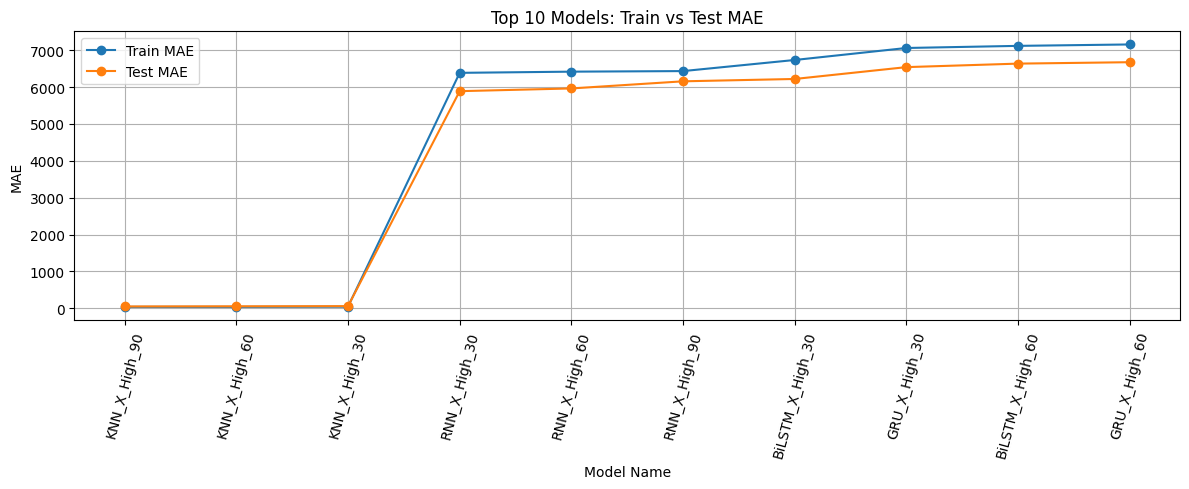

In [18]:
import matplotlib.pyplot as plt

# Select top 10 models by test MAE
top_10 = results_df.sort_values(by='test_mae', ascending=True).head(10)

plt.figure(figsize=(12, 5))
plt.plot(top_10['Model'], top_10['train_mae'], marker='o', label='Train MAE')
plt.plot(top_10['Model'], top_10['test_mae'], marker='o', label='Test MAE')

plt.xticks(rotation=75)
plt.xlabel('Model Name')
plt.ylabel('MAE')
plt.title('Top 10 Models: Train vs Test MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 8. Relation btw. No of Input Days and Model Performance

1. **Extract Time Windows**
   - From each model name in `top_10`  
   - Split string by `_` → take last part (time window)  

2. **Count Frequencies**
   - `value_counts()` → count models per time window  
   - Sort by count (descending)  

3. **Plot Bar Chart**
   - X-axis: time windows  
   - Y-axis: number of models in Top 50  

4. **Customize**
   - Add labels (x, y), title  
   - Grid only on Y-axis for readability  
   - `tight_layout()` → clean layout  

5. **Show Chart**
   - `plt.show()` → display bar chart of time-window frequencies  

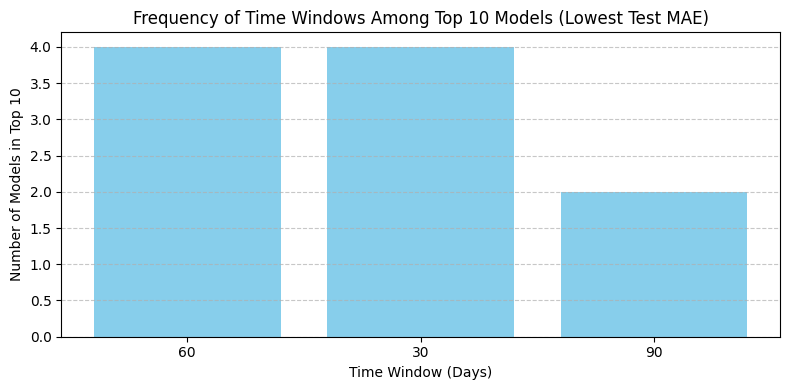

In [19]:
# Select top 10 models by test MAE
top_10 = results_df.sort_values(by='test_mae', ascending=True).head(10)

# Extract time window from model names
time_windows = pd.Series([i.split('_')[-1] for i in top_10['Model']])
time_counts = time_windows.value_counts().sort_values(ascending=False)  # Sort by count

# Plotting
plt.figure(figsize=(8, 4))
plt.bar(time_counts.index, time_counts.values, color='skyblue')

# Labels and aesthetics
plt.xlabel('Time Window (Days)')
plt.ylabel('Number of Models in Top 10')
plt.title('Frequency of Time Windows Among Top 10 Models (Lowest Test MAE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

1. **Select Top 50 Models**
   - Sort by `test_mae` → best 50 models  

2. **Extract Target Column**
   - From model names → split by `_`  
   - Take second last part as target column name  

3. **Count Frequencies**
   - `value_counts()` → count occurrences of each target  
   - Sort by frequency (descending)  

4. **Plot Bar Chart**
   - X-axis: target column names  
   - Y-axis: number of models in Top 50  

5. **Customize**
   - Add labels, title  
   - Grid on Y-axis for readability  
   - Use `tight_layout()` to prevent label overlap  

6. **Show Chart**
   - `plt.show()` → display bar chart of target column frequencies

### 9. Which model works in general better on this task?

1. **Select Top 10 Models**
   - Sort `results_df` by `test_mae`  
   - Keep best 10 models  

2. **Extract Model Types**
   - From model names → split by `_`  
   - Take the first part as model type (e.g., KNN, LSTM)  

3. **Count Frequencies**
   - `value_counts()` → count occurrences of each model type  
   - Sort counts in descending order  

4. **Plot Bar Chart**
   - X-axis: model types  
   - Y-axis: number of models in Top 50  

5. **Show Chart**
   - `plt.show()` → display bar chart of model type distribution  

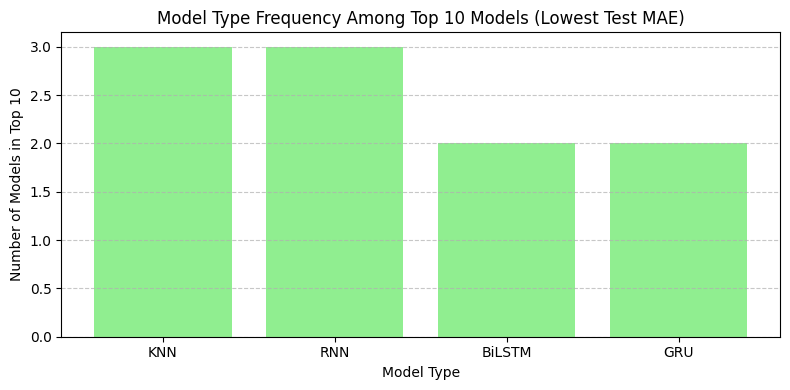

In [20]:
# Select top 4 models by test MAE
top_4 = results_df.sort_values(by='test_mae', ascending=True).head(4)

# Extract model type from names
model_types = pd.Series([i.split('_')[0] for i in top_10['Model']])
model_counts = model_types.value_counts().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(8, 4))
plt.bar(model_counts.index, model_counts.values, color='lightgreen')

# Labels and aesthetics
plt.xlabel('Model Type')
plt.ylabel('Number of Models in Top 10')
plt.title('Model Type Frequency Among Top 10 Models (Lowest Test MAE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 10. Saving Models

1. **Save Results Table**
   - `results_df.to_csv('models.csv')` → save metrics as CSV  

2. **Save Trained Models**
   - `joblib.dump(trained_models, 'trained_models.joblib')`  
   - Stores all fitted ML + DL models + their metrics  

3. **Load Models**
   - `loaded_models = joblib.load('trained_models.joblib')`  
   - Reload models/metrics into memory for reuse  

In [21]:
import joblib

results_df.to_csv('models.csv')
joblib.dump(trained_models, 'trained_models.joblib')

loaded_models = joblib.load('trained_models.joblib')

### 11. Loading Saved Models

1. **Access Specific Model**
   - `loaded_models['KNN_X_High_60'] & ['RNN_X_High_60']`  
   - Retrieves dictionary with:
     - Trained model object  
     - Train/Test MAE & RMSE metrics  

2. **Extract Model**
   - `model = loaded_models['KNN_X_High_60']['model']`  
   - Assigns the trained KNN regressor to `model` variable  
   - Now can be used for `.predict()` on new data  

In [25]:
# Loading the KNN model
loaded_models['KNN_X_High_60']
model_knn = loaded_models['KNN_X_High_60']['model']

# Loading the RNN model
loaded_models['RNN_X_High_60']
model_rnn = loaded_models['RNN_X_High_60']['model']

### 12. Model Inference

### 1. **Inspect Input Sample**

* `print(chunked_data['X_High_60'][5])`

  * Displays the 6th sample from the feature set `X_High_60` (which corresponds to 60-day input data).

---

### 2. **Make Prediction for KNN Model**

* `model_knn.predict([chunked_data['X_High_60'][5]])`

  * Wrap the sample in a list to ensure a 2D shape `(1, n_features)`.
  * Outputs the predicted value for that input using the trained **KNN\_X\_High\_60** model.

---

### 3. **Make Prediction for RNN Model**

* `model_rnn.predict([chunked_data['X_High_60'][5]])`

  * Similarly, wrap the sample in a list for the RNN model to maintain the correct input shape.
  * Outputs the predicted value for that input using the trained **RNN\_X\_High\_60** model.


In [30]:
# Select the input sample (6th one)
sample_index = 5
input_sample = chunked_data['X_High_60'][sample_index]

# Print input data
print(f"\n📥 Input Sample ({sample_index=}) [X_High_60]:")
print(input_sample)

# KNN Prediction
knn_pred = model_knn.predict([input_sample])[0]
print(f"\n🤖 KNN Prediction: {knn_pred:.2f}")

# RNN Prediction (reshape input to (1, timesteps, 1))
rnn_input = np.expand_dims(input_sample, axis=(0, -1))
rnn_pred = model_rnn.predict(rnn_input, verbose=0)[0][0]
print(f"🧠 RNN Prediction: {rnn_pred:.2f}")


📥 Input Sample (sample_index=5) [X_High_60]:
[1662.1  1639.9  1631.55 1671.15 1627.4  1668.45 1615.15 1644.45 1644.4
 1626.5  1645.   1613.65 1633.55 1610.9  1598.35 1554.15 1605.9  1616.7
 1621.35 1645.9  1676.1  1731.65 1713.7  1771.65 1795.45 1744.5  1742.8
 1753.1  1764.15 1767.8  1781.05 1818.15 1751.6  1757.05 1726.65 1783.3
 1727.9  1773.85 1719.15 1721.   1730.85 1765.25 1692.25 1680.45 1645.
 1571.3  1630.95 1621.2  1585.25 1604.   1629.2  1579.4  1593.3  1575.85
 1609.4  1557.85 1545.55 1555.5  1534.05 1467.4 ]

🤖 KNN Prediction: 1534.34
🧠 RNN Prediction: 1701.86
